## This notebook imports a csv file with text from sustainable finance standards and text from non sustainable finance standards. It finetunes BertForSequenceClassification to classify if a text is about sustainable finance or not



In [ ]:
#install the huggingface library
!pip install transformers

In [1]:
#import libraries
import tensorflow as tf
import torch
import pandas as pd
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import os
import matplotlib.pyplot as plt
import random
import time
import datetime
import numpy as np
import seaborn as sns


In [2]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')


Found GPU at: /device:GPU:0


In [3]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [4]:
# Load the training dataset into a pandas dataframe.
df = pd.read_csv("/content/training.csv")

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)


Number of training sentences: 14,000



,standard_type,document_title,document_text,label
3598,Non-sustainable standards,Illustrative_discloser IFRS 9 for Banks,information would be an onerous task. This cou...,1
10115,Non-sustainable standards,ias-32-financial-instruments-presentation,"10, IFRS 12 and IAS 27 ), issued in October 20...",1
3425,climate bonds standard,"Globally recognised, Paris-aligned Certificati...",Climate Bonds Standard Version 4.0 353.1.2. Cl...,0
1997,Non-sustainable standards,ias-8-accounting-policies-changes-in-accountin...,be a third- party body or a related party of t...,1
10620,Non-sustainable standards,Illustrative_discloser IFRS 9 for Banks,vesting conditions are met. If the transaction...,1
6937,GreenFin Label,Understanding Impact Performance: Financial In...,first-time access to financial services. For e...,0
2954,Freshfields,A Legal Framework For Impact,engagement and integrating that analysis in th...,0
11224,Non-sustainable standards,ifrs-9-financial-instruments,with a higher return. The managers responsible...,1
10168,Non-sustainable standards,Conceptual Framework for Financial Reporting,a single transaction; and (f) a risk exposure ...,1
12884,un environment programme finance initiative,application of the EU Taxonomy to core banking...,for banks’ sustainability disclosures under th...,0


In [5]:
# Get the lists of sentences and their standard type.
sentences = df.document_text.values
labels = df.label.values

In [6]:
# Load the test dataset into a pandas dataframe.
df_test = pd.read_csv("/content/test.csv")

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))

# Display 10 random rows from the data.
df_test.sample(10)

Number of test sentences: 11,857



,standard_type,document_title,document_text,label
10529,climate disclosure standards board,Application guidance for biodiversity-related ...,"Global change biology, 26(2), 760-771. Availab...",0
564,un environment programme finance initiative,application of the EU Taxonomy to core banking...,relevant to Mitigation. These different types ...,0
6094,Non-sustainable standards,ifrs-9-financial-instruments,sale (see paragraph B3.2.14). If a transfer of...,1
2653,Integrated Reporting,International Framework,including: ‒Buildings ‒Equipment ‒Infrastructu...,0
537,GreenFin Label,Financial Innovation towards solidarity,desire to contribute to a social utility initi...,0
9693,un environment programme finance initiative,Common Framework OF Sustainable Finance Taxono...,"this document, will support more countries to ...",0
8054,un environment programme finance initiative,Practical Approaches to Applying the EU Taxono...,Practical Approaches to Applying the EU Taxono...,0
4221,Freshfields,A Legal Framework For Impact,commitments from its institutional investor me...,0
2510,Non-sustainable standards,ifrs-13-fair-value-measurement,markets. Dealer markets also exist for some ot...,1
3560,Partnership for Carbon Accounting Financials,Financed Emissions,"electricity, steam, heating, or cooling is gen...",0


In [7]:
# Get the lists of test sentences and their standard type.
test_sentences = df_test.document_text.values
test_labels = df_test.label.values

In [8]:
#load the BERT Tokenzier
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
#test out the tokenizer
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  challenges and existing accounting guidance on how to measure and report GHG emissions associated with investments. In particular, they voiced concerns about the accuracy and completeness of the reported data. Methodology Challenges . Accurately capturing Scope 3 GHG emissions also has methodological challenges, including estimating GHG emissions for suppliers that do not calculate their own emissions, defining an appropriate calculation approach for each Scope 3 category, and recognizing double counting
Tokenized:  ['challenges', 'and', 'existing', 'accounting', 'guidance', 'on', 'how', 'to', 'measure', 'and', 'report', 'g', '##hg', 'emissions', 'associated', 'with', 'investments', '.', 'in', 'particular', ',', 'they', 'voiced', 'concerns', 'about', 'the', 'accuracy', 'and', 'complete', '##ness', 'of', 'the', 'reported', 'data', '.', 'methodology', 'challenges', '.', 'accurately', 'capturing', 'scope', '3', 'g', '##hg', 'emissions', 'also', 'has', 'method', '##ological', '

In [10]:
# Print the test sentence.
print(' Original: ', test_sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(test_sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(test_sentences[0])))

 Original:  Practical Approaches to Applying the EU Taxonomy to Bank Lending 32 Mandatory application of the EU Taxonomy to bank lending (loans and advances)disclosures, this disclosure should be accompanied by supporting detail setting out the basis for this disclosure and methods used for its preparation along with a clear expla - nation of how it differs from mandatory reporting. Further guidance on voluntary reporting and use of estimates for eligibility reporting in the first year(s) of reporting is provided by
Tokenized:  ['practical', 'approaches', 'to', 'applying', 'the', 'eu', 'taxonomy', 'to', 'bank', 'lending', '32', 'mandatory', 'application', 'of', 'the', 'eu', 'taxonomy', 'to', 'bank', 'lending', '(', 'loans', 'and', 'advances', ')', 'disclosure', '##s', ',', 'this', 'disclosure', 'should', 'be', 'accompanied', 'by', 'supporting', 'detail', 'setting', 'out', 'the', 'basis', 'for', 'this', 'disclosure', 'and', 'methods', 'used', 'for', 'its', 'preparation', 'along', 'with'

Next step includes setting the required formatting for BERT

1. Add special tokens to the start and end of each sentence:


*   The [sep] tokens for separating sentences. This is needed for BERT for both single sentences and multiple sentences
*   The [cls] tokens for classifications. It is needed to make classification predictions and added at the beginning


2. Pad & truncate all sentences to a single constant length: BERT requires all sentences to be the same length, therefore padding is added with the [pad] token. Pad to length of 128


3. Differentiate real tokens from padding tokens with the "attention mask"

In [11]:
#add the [sep] tokens
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])


Original:  challenges and existing accounting guidance on how to measure and report GHG emissions associated with investments. In particular, they voiced concerns about the accuracy and completeness of the reported data. Methodology Challenges . Accurately capturing Scope 3 GHG emissions also has methodological challenges, including estimating GHG emissions for suppliers that do not calculate their own emissions, defining an appropriate calculation approach for each Scope 3 category, and recognizing double counting
Token IDs: [101, 7860, 1998, 4493, 9529, 8606, 2006, 2129, 2000, 5468, 1998, 3189, 1043, 25619, 11768, 3378, 2007, 10518, 1012, 1999, 3327, 1010, 2027, 6126, 5936, 2055, 1996, 10640, 1998, 3143, 2791, 1997, 1996, 2988, 2951, 1012, 16134, 7860, 1012, 14125, 11847, 9531, 1017, 1043, 25619, 11768, 2036, 2038, 4118, 10091, 7860, 1010, 2164, 9765, 22835, 1043, 25619, 11768, 2005, 20141, 2008, 2079, 2025, 18422, 2037, 2219, 11768, 1010, 12854, 2019, 6413, 17208, 3921, 2005, 2169, 

In [12]:
#add the [sep] tokens
# Tokenize all of the sentences and map the tokens to thier word IDs.
test_input_ids = []

# For every sentence...
for sent in test_sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    test_input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', test_sentences[0])
print('Token IDs:', test_input_ids[0])


Original:  Practical Approaches to Applying the EU Taxonomy to Bank Lending 32 Mandatory application of the EU Taxonomy to bank lending (loans and advances)disclosures, this disclosure should be accompanied by supporting detail setting out the basis for this disclosure and methods used for its preparation along with a clear expla - nation of how it differs from mandatory reporting. Further guidance on voluntary reporting and use of estimates for eligibility reporting in the first year(s) of reporting is provided by
Token IDs: [101, 6742, 8107, 2000, 11243, 1996, 7327, 25274, 2000, 2924, 18435, 3590, 10915, 4646, 1997, 1996, 7327, 25274, 2000, 2924, 18435, 1006, 10940, 1998, 9849, 1007, 19380, 2015, 1010, 2023, 19380, 2323, 2022, 5642, 2011, 4637, 6987, 4292, 2041, 1996, 3978, 2005, 2023, 19380, 1998, 4725, 2109, 2005, 2049, 7547, 2247, 2007, 1037, 3154, 4654, 24759, 2050, 1011, 3842, 1997, 2129, 2009, 12980, 2013, 10915, 7316, 1012, 2582, 8606, 2006, 10758, 7316, 1998, 2224, 1997, 1003

In [13]:
#pad and truncate sentences to a max length
#check the maximum sentence length
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  353


In [14]:
#pad and truncate sentences to a max length
#check the maximum sentence length
print('Max sentence length: ', max([len(sen) for sen in test_input_ids]))

Max sentence length:  285


In [15]:
# We'll use the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# randomly chosen 380 because its slightly larger than 353
MAX_LEN = 380

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 380 values...

Padding token: "[PAD]", ID: 0

Done.


In [16]:
# Set the maximum sequence length.
# randomly chosen 380 because we set the training data at 380
MAX_LEN = 380

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates pad and truncate at the end of the sequence,
# as opposed to the beginning.
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long",
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 380 values...

Padding token: "[PAD]", ID: 0

Done.


In [17]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:

    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]

    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [18]:
# Create attention masks
test_attention_masks = []

# For each sentence...
for sent in test_input_ids:

    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]

    # Store the attention mask for this sentence.
    test_attention_masks.append(att_mask)

In [19]:
# share inputs in input ids and labels in labels
train_inputs = input_ids
train_labels = labels
validation_inputs = test_input_ids
validation_labels = test_labels

# Do the same for the masks.
train_masks = attention_masks
validation_masks = test_attention_masks
train_ = labels
test_ = test_labels

In [20]:
print('Max sentence length: ', max([len(sen) for sen in train_masks]))

Max sentence length:  380


In [21]:
print('Max sentence length: ', max([len(sen) for sen in test_attention_masks]))

Max sentence length:  380


In [22]:
# Convert all inputs and labels into torch tensors, the required datatype
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [23]:
# The DataLoader needs to know our batch size for training, so we specify it
# here.
# For fine-tuning BERT on a specific task, the recommended is batch size of
# 16 or 32.

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [24]:
# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [25]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [26]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
#  'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, but 2e-5 was used
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
# Number of training epochs (recommended between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [28]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [29]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [30]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode.
    # the call to `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP#scrollTo=68xreA9JAmG5)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # unpack the batch and copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # The call to `model` always returns a tuple, so  pull the
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that the
        # average loss at the end can be calclated. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    875.    Elapsed: 0:00:43.
  Batch    80  of    875.    Elapsed: 0:01:28.
  Batch   120  of    875.    Elapsed: 0:02:12.
  Batch   160  of    875.    Elapsed: 0:02:56.
  Batch   200  of    875.    Elapsed: 0:03:40.
  Batch   240  of    875.    Elapsed: 0:04:24.
  Batch   280  of    875.    Elapsed: 0:05:08.
  Batch   320  of    875.    Elapsed: 0:05:52.
  Batch   360  of    875.    Elapsed: 0:06:37.
  Batch   400  of    875.    Elapsed: 0:07:21.
  Batch   440  of    875.    Elapsed: 0:08:05.
  Batch   480  of    875.    Elapsed: 0:08:49.
  Batch   520  of    875.    Elapsed: 0:09:33.
  Batch   560  of    875.    Elapsed: 0:10:17.
  Batch   600  of    875.    Elapsed: 0:11:01.
  Batch   640  of    875.    Elapsed: 0:11:45.
  Batch   680  of    875.    Elapsed: 0:12:30.
  Batch   720  of    875.    Elapsed: 0:13:14.
  Batch   760  of    875.    Elapsed: 0:13:58.
  Batch   800  of    875.    Elapsed: 0:14:42.
  Batch   840  of

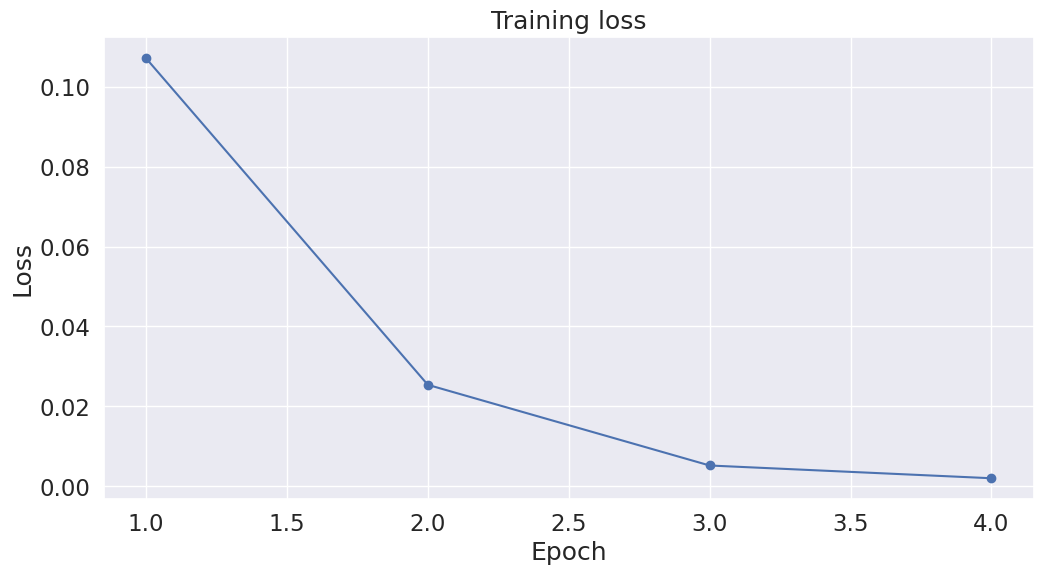

In [36]:
%matplotlib inline

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Create a list of epoch numbers starting from 1.
epochs = range(1, len(loss_values) + 1)

# Plot the learning curve.
plt.plot(epochs, loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Ensure the labels are displayed
plt.show()

In [32]:
#save the trained model

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')